In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import GCRCatalogs
import healpy
import pickle,sys
import mysql
from mysql.connector import Error
import clmm
from clmm.dataops import compute_galaxy_weights
from clmm import Cosmology
from scipy.integrate import simps
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040)
cursor = conn.cursor(dictionary=True, buffered=True)

In [2]:
import _utils_photometric_redshifts
import _utils_lensing_profiles
import _utils_extract_sources_in_cosmoDC2
import _config_extract_sources_in_cosmoDC2 
import _config_lensing_profiles
from astropy.table import QTable, Table, vstack, join, hstack

['DSt_true', 'DSx_true', 'W_l_true', 'radius_true', 'DSt_flex', 'DSx_flex', 'W_l_flex', 'radius_flex', 'DSt_bpz', 'DSx_bpz', 'W_l_bpz', 'radius_bpz']


## Cosmodc2 with qserv & GCRCatalogs

In [3]:
def qserv_query(ra, dec, rmax = 10):
    r"""
    quantities wanted + cuts
    Attributes:
    -----------
    z: float
        lens redshift
    ra: float
        lens right ascension
    dec: float
        lens declinaison
    rmax: float
        maximum radius
    """
    zmax = 3.
    zmin = 0
    theta_max = (rmax/lens_distance) * (180./np.pi)
    query = "SELECT data.coord_ra as ra, data.coord_dec as dec, data.redshift as z, "
    query += "data.galaxy_id as galaxy_id, "
    query += "data.mag_i, data.mag_r, data.mag_y, "
    query += "data.shear_1 as shear1, data.shear_2 as shear2, data.convergence as kappa, "
    query += "data.ellipticity_1_true as e1_true, data.ellipticity_2_true as e2_true " 
    query += "FROM cosmoDC2_v1_1_4_image.data as data "
    query += f"WHERE data.redshift >= {zmin} AND data.redshift < {zmax} "
    query += f"AND scisql_s2PtInCircle(coord_ra, coord_dec, {ra}, {dec}, {theta_max}) = 1 "
    query += f"AND data.mag_i <= 25 "
    query += ";" 
    return query

In [4]:
#cluster
lens_cat = np.load('../data/lens_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl', allow_pickle = True)
index = 1
z, ra, dec = lens_cat['redshift'][index], lens_cat['ra'][index], lens_cat['dec'][index]

In [5]:
z, ra, dec

(0.5712697, 56.920376528125075, -27.20434071042304)

### true shapes, true redshifts

In [6]:
lens_distance=cosmo.eval_da(z)
bckgd_galaxy_catalog_truth=_utils_extract_sources_in_cosmoDC2.extract(qserv_query = qserv_query( ra, dec, rmax = 6),
                                        conn_qserv=conn, cosmo=cosmo)

In [7]:
len(bckgd_galaxy_catalog_truth)

29869

In [8]:
gc_bpz  = "cosmoDC2_v1.1.4_image_with_photozs_v1"
gc_flex = "cosmoDC2_v1.1.4_image_with_photozs_flexzboost_v1"
#list of healpix in cosmoDC2
healpix_dc2 = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image").get_catalog_info()['healpix_pixels']
z_bins  = GCRCatalogs.load_catalog(gc_flex).photoz_pdf_bin_centers
z_bins[0] = 1e-7
photoz_gc=[gc_bpz, gc_flex]
photoz_label=['_bpz', '_flex']
#hp = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image").get_catalog_info()['healpix_pixels']
#healpix_list = gc_flex.get_catalog_info()['catalogs'][1]['healpix_pixels']

In [9]:
def query_photoz():
    return ['photoz_pdf', 'photoz_mean','photoz_mode','photoz_odds','galaxy_id']

In [10]:
#extract photometric redshifts with GCRCatalogs
print('extracting photoz redshift infos (GCRCatalogs)')
id_gal=bckgd_galaxy_catalog_truth['galaxy_id']
ras=bckgd_galaxy_catalog_truth['ra']
decs=bckgd_galaxy_catalog_truth['dec']
#find all different healpix pixels
healpix = np.array(np.unique(healpy.ang2pix(32, ras, decs, nest=False, lonlat=True)))
print(healpix)
table_photoz = Table()
table_photoz['galaxy_id'] = id_gal
for k, gc_ in enumerate(photoz_gc):
    print(f'----> extraction in {gc_}')
    pz_table = Table(names = ['sigmac_photoz', 'p_background', 'photoz_dispersion', 
                          'sigmac_estimate_0', 'sigmac_estimate_1', 'sigmac_estimate_2', 
                          'z_estimate_0', 'z_estimate_1', 'z_estimate_2', 
                          'galaxy_id', 'photoz_mean', 'photoz_mode', 'photoz_odds'])
    photoz_gc_ = GCRCatalogs.load_catalog(gc_)
    for i, hp in enumerate(healpix):
        #browse healpix pixels
        print(f'-----> heapix pixel = ' + str(hp))
        chunk = photoz_gc_.get_quantities(query_photoz(), native_filters=[f'healpix_pixel=={hp}'], return_iterator=True)
        for j in range(3):
            #browse chunk data
            print('chunk = ' + str(j))
            dat_extract_photoz_chunk = Table(next(chunk))
            print(f'full healpix = ' + str(len(dat_extract_photoz_chunk['galaxy_id'])))
            #use only selected galaxies
            dat_extract_photoz_chunk_truncated = dat_extract_photoz_chunk[np.isin(dat_extract_photoz_chunk['galaxy_id'],
                                                                                  table_photoz['galaxy_id'])]
           # if len(dat_extract_photoz_chunk_truncated['galaxy_id']) == 0: continue

            print('truncated healpix = ' + str(len(dat_extract_photoz_chunk_truncated['galaxy_id'])))
            pzbins_table=np.array([z_bins for i in range(len(dat_extract_photoz_chunk_truncated['photoz_pdf'].data))])

            #compute WL weights with 
            pz_quantities_chunk = _utils_photometric_redshifts.compute_photoz_quantities(z, dat_extract_photoz_chunk_truncated['photoz_pdf'], 
                                                                   pzbins_table, n_samples_per_pdf=3, cosmo=cosmo,
                                                                   use_clmm=False)
            pz_quantities_chunk['galaxy_id'] = dat_extract_photoz_chunk_truncated['galaxy_id']
            pz_quantities_chunk['photoz_mean'] = dat_extract_photoz_chunk_truncated['photoz_mean']
            pz_quantities_chunk['photoz_mode'] = dat_extract_photoz_chunk_truncated['photoz_mode']
            pz_quantities_chunk['photoz_odds'] = dat_extract_photoz_chunk_truncated['photoz_odds']
            pz_table = vstack([pz_table, pz_quantities_chunk])
    colnames = pz_table.colnames
    for name in colnames:
        if name!='galaxy_id':
            pz_table.rename_column(name, name + photoz_label[k])
    bckgd_galaxy_catalog_truth = join(Table(bckgd_galaxy_catalog_truth), pz_table, keys='galaxy_id')

extracting photoz redshift infos (GCRCatalogs)
[8916]
----> extraction in cosmoDC2_v1.1.4_image_with_photozs_v1
-----> heapix pixel = 8916
chunk = 0
full healpix = 825518
truncated healpix = 18783


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 1
full healpix = 664206
truncated healpix = 10465


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 2
full healpix = 138819
truncated healpix = 621
----> extraction in cosmoDC2_v1.1.4_image_with_photozs_flexzboost_v1


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


-----> heapix pixel = 8916
chunk = 0
full healpix = 825518
truncated healpix = 18783


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 1
full healpix = 664206
truncated healpix = 10465


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 2
full healpix = 138819
truncated healpix = 621


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


In [11]:
print(bckgd_galaxy_catalog_truth.colnames)

['ra', 'dec', 'z', 'galaxy_id', 'mag_i', 'mag_r', 'mag_y', 'shear1', 'shear2', 'kappa', 'e1_true', 'e2_true', 'g1', 'g2', 'e1', 'e2', 'sigmac_photoz_bpz', 'p_background_bpz', 'photoz_dispersion_bpz', 'sigmac_estimate_0_bpz', 'sigmac_estimate_1_bpz', 'sigmac_estimate_2_bpz', 'z_estimate_0_bpz', 'z_estimate_1_bpz', 'z_estimate_2_bpz', 'photoz_mean_bpz', 'photoz_mode_bpz', 'photoz_odds_bpz', 'sigmac_photoz_flex', 'p_background_flex', 'photoz_dispersion_flex', 'sigmac_estimate_0_flex', 'sigmac_estimate_1_flex', 'sigmac_estimate_2_flex', 'z_estimate_0_flex', 'z_estimate_1_flex', 'z_estimate_2_flex', 'photoz_mean_flex', 'photoz_mode_flex', 'photoz_odds_flex']


In [13]:
mask_mag= bckgd_galaxy_catalog_truth['mag_i'] < 24.5
mask_mag*= bckgd_galaxy_catalog_truth['mag_r'] < 28
bckgd_galaxy_catalog = bckgd_galaxy_catalog_truth[mask_mag]

In [14]:
theta_rad = 6/lens_distance
theta_arcmin = theta_rad * 3437.75
S_deg_2 = np.pi*theta_arcmin**2
print(f'n_gal = {len(bckgd_galaxy_catalog)/S_deg_2:.1f} gal.armin^(-2)')

n_gal = 27.2 gal.armin^(-2)


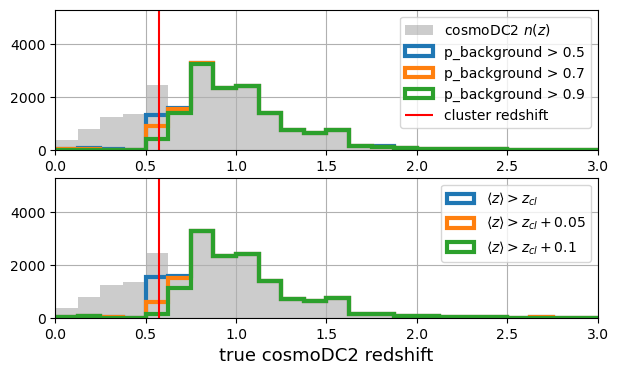

In [15]:
photoz = 'bpz'
plt.figure(figsize=(7,4))
plt.subplot(2, 1, 1)
bins_ = np.linspace(0, 3, 25)
plt.hist(bckgd_galaxy_catalog['z'], bins=bins_,  color='gray', alpha=.4,  lw=3, ls='--', label = r'cosmoDC2 $n(z)$')
mask_p1 = bckgd_galaxy_catalog[f'p_background_{photoz}'] > 0.5
plt.hist(bckgd_galaxy_catalog['z'][mask_p1], bins=bins_, histtype = 'step', lw=3, label = 'p_background > 0.5')
mask_p2 = bckgd_galaxy_catalog[f'p_background_{photoz}'] > 0.7
plt.hist(bckgd_galaxy_catalog['z'][mask_p2], bins=bins_, histtype = 'step', lw=3, label = 'p_background > 0.7')
mask_p3 = bckgd_galaxy_catalog[f'p_background_{photoz}'] > 0.9
plt.hist(bckgd_galaxy_catalog['z'][mask_p3], bins=bins_, histtype = 'step', lw=3, label = 'p_background > 0.9')
plt.vlines(z, 0, 10000, color='r', label = 'cluster redshift')
plt.ylim(0,5300)
plt.xlim(0, 3)
plt.legend()
plt.grid(True)
plt.xlabel('true cosmoDC2 redshift', fontsize=13)
plt.subplot(2, 1, 2)
plt.hist(bckgd_galaxy_catalog['z'], bins=bins_,  color='gray', alpha=.4,  lw=3)
mask_z1 = bckgd_galaxy_catalog[f'photoz_mean_{photoz}'] > z
plt.hist(bckgd_galaxy_catalog['z'][mask_z1], bins=bins_, histtype = 'step', lw=3, label = r'$\langle z \rangle > z_{cl}$')
mask_z2 = bckgd_galaxy_catalog[f'photoz_mean_{photoz}'] > z + .05
plt.hist(bckgd_galaxy_catalog['z'][mask_z2], bins=bins_, histtype = 'step', lw=3, label = r'$\langle z \rangle > z_{cl} + 0.05$')
mask_z3 = bckgd_galaxy_catalog[f'photoz_mean_{photoz}'] > z + 0.1
plt.hist(bckgd_galaxy_catalog['z'][mask_z3], bins=bins_, histtype = 'step', lw=3, label = r'$\langle z \rangle > z_{cl} + 0.1$')
plt.vlines(z, 0, 10000, color='r')
plt.ylim(0,5300)
plt.xlim(0, 3)
plt.legend()
plt.grid(True)
plt.xlabel('true cosmoDC2 redshift', fontsize=13)
plt.savefig('nz.png', bbox_inches='tight', dpi=300)

In [16]:
cl = clmm.galaxycluster.GalaxyCluster('halo', ra, dec, z, clmm.gcdata.GCData(bckgd_galaxy_catalog))
theta, g_t, g_x = cl.compute_tangential_and_cross_components(is_deltasigma=False, cosmo=None)
R = lens_distance * theta
z_gal = bckgd_galaxy_catalog['z']

In [17]:
r_edges = np.linspace(0, 6, 10)
r_bins = [[r_edges[i], r_edges[i+1]] for i in range(len(r_edges)-1)]

In [18]:
def contamination(R, mask_pz):
    R_mask_pz = R[mask_pz]
    z_mask_pz = z_gal[mask_pz]
    c = []
    for i, r_bin in enumerate(r_bins):
        mask_r = (R_mask_pz <= r_bin[1])*(R_mask_pz >= r_bin[0])
        R_mask_pz_in_r = R_mask_pz[mask_r]
        z_mask_pz_in_r = z_mask_pz[mask_r]
        z_foreground_in_r = z_mask_pz_in_r[z_mask_pz_in_r < z]
        c.append(len(z_foreground_in_r)/len(z_mask_pz_in_r))
    return np.array(c)

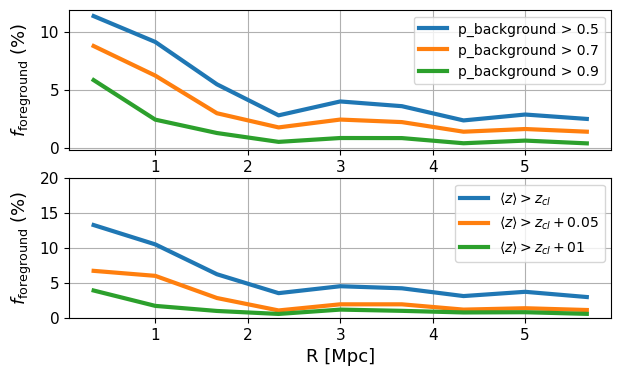

In [19]:
plt.figure(figsize=(7,4))
plt.subplot(2, 1, 1)
plt.plot(np.mean(r_bins, axis=1), 100*contamination(R, mask_p1), 'C0', label = 'p_background > 0.5',  lw=3, )
plt.plot(np.mean(r_bins, axis=1), 100*contamination(R, mask_p2), 'C1', label = 'p_background > 0.7',  lw=3,)
plt.plot(np.mean(r_bins, axis=1), 100*contamination(R, mask_p3), 'C2', label = 'p_background > 0.9',  lw=3,)
plt.legend()
plt.grid(True)
plt.ylabel(r'$f_{\rm foreground}$ (%)', fontsize=13)
plt.xlabel('R [Mpc]', fontsize=13)
plt.tick_params(axis='both', which = 'both', labelsize= 11)
plt.subplot(2, 1, 2)
plt.plot(np.mean(r_bins, axis=1), 100*contamination(R, mask_z1), '-', label = r'$\langle z \rangle > z_{cl}$',  lw=3,)
plt.plot(np.mean(r_bins, axis=1), 100*contamination(R, mask_z2), '-', label = r'$\langle z \rangle > z_{cl} + 0.05$',  lw=3,)
plt.plot(np.mean(r_bins, axis=1), 100*contamination(R, mask_z3), '-', label = r'$\langle z \rangle > z_{cl} + 01$',  lw=3,)
plt.legend()
plt.grid(True)
plt.ylabel(r'$f_{\rm foreground}$ (%)', fontsize=13)
plt.xlabel('R [Mpc]', fontsize=13)
plt.ylim(0,20)
plt.tick_params(axis='both', which = 'both', labelsize= 11)
plt.savefig('contamination.png', bbox_inches='tight', dpi=300)